# 日経平均株価 15分足

### 一つ上のディレクトリをパスに追加

In [111]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

### ライブラリをここで一括インポート

In [112]:
import datetime

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

from funcs.common import get_name_15min_chart, get_name_15min_chart_now

## yfinance による株価データの取得

In [113]:
code = "N225"
symbol = f"^{code}"
ticker = yf.Ticker(symbol)
df = ticker.history(period="1d", interval="15m")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-08-26 09:00:00+09:00,42619.660156,42703.269531,42431.320312,42491.421875,0,0.0,0.0
2025-08-26 09:15:00+09:00,42495.781250,42574.058594,42438.019531,42468.019531,0,0.0,0.0
2025-08-26 09:30:00+09:00,42471.171875,42498.089844,42215.621094,42229.878906,0,0.0,0.0
2025-08-26 09:45:00+09:00,42225.878906,42315.460938,42137.621094,42297.468750,0,0.0,0.0
2025-08-26 10:00:00+09:00,42300.121094,42406.699219,42264.820312,42404.671875,0,0.0,0.0
2025-08-26 10:15:00+09:00,42402.570312,42408.261719,42349.921875,42355.550781,0,0.0,0.0
2025-08-26 10:30:00+09:00,42356.378906,42381.359375,42326.488281,42362.851562,0,0.0,0.0
2025-08-26 10:45:00+09:00,42365.558594,42384.929688,42320.699219,42333.718750,0,0.0,0.0
2025-08-26 11:00:00+09:00,42329.121094,42379.640625,42329.121094,42366.199219,0,0.0,0.0


## 前日終値の取得

In [114]:
# 過去一週間のデータを取得
td = datetime.timedelta(days=7)
dt_first = df.index[0]
dt_prev = dt_first - td
df_last = ticker.history(interval="1d", start=str(dt_prev.date()))
print(df_last["Close"])
n = len(df_last)
lastclose = df_last[n - 2 : n - 1]["Close"].iloc[0]
# 確認のため出力
df_last[n - 2 : n - 1]["Close"]

Date
2025-08-19 00:00:00+09:00    43546.289062
2025-08-20 00:00:00+09:00    42888.550781
2025-08-21 00:00:00+09:00    42610.171875
2025-08-22 00:00:00+09:00    42633.289062
2025-08-25 00:00:00+09:00    42807.820312
2025-08-26 00:00:00+09:00    42428.351562
Name: Close, dtype: float64


Date
2025-08-25 00:00:00+09:00    42807.820312
Name: Close, dtype: float64

## ローソク足チャート（小さいサイズ）

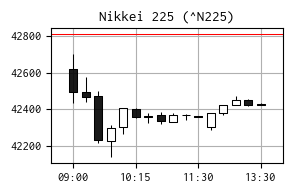

In [115]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 9

fig, ax = plt.subplots(figsize=(3, 2))
mpf.plot(
    df,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.axhline(y=lastclose, color="red", linewidth=0.75)
ax.set_ylabel(None)
ax.grid()

if "shortName" in ticker.info:
    ax.set_title(f"{ticker.info['shortName']} ({symbol})")
elif "longName" in ticker.info:
    ax.set_title(f"{ticker.info['longName']} ({symbol})")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart(code, dt_first))
plt.show()